# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt

% matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
def compute_channel(row, channel):
    if(channel in row['channels']):
        return 1
    return 0

In [6]:
#one-hot encoding
portfolio['email_adv']=portfolio.apply(lambda x: compute_channel(x,'email'), axis=1)
portfolio['mobile_adv']=portfolio.apply(lambda x: compute_channel(x,'mobile'), axis=1)
portfolio['social_adv']=portfolio.apply(lambda x: compute_channel(x,'social'), axis=1)
portfolio['web_adv']=portfolio.apply(lambda x: compute_channel(x,'web'), axis=1)

#portfolio.drop('channels',inplace=True,axis=1)
portfolio

,channels,difficulty,duration,id,offer_type,reward,email_adv,mobile_adv,social_adv,web_adv
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


In [7]:
#compute the reward-to-difficulty ratio. This gives a sense of the cash profit for the customer for a particular offer.
def reward_ratio(row):
    if row['difficulty'] == 0:
        return 0
    else:
        return row['reward']/(float)(row['difficulty'])

In [8]:
#add reward_ratio column
portfolio['reward_ratio'] = portfolio.apply(lambda x : reward_ratio(x),axis=1)
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,email_adv,mobile_adv,social_adv,web_adv,reward_ratio
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1.00
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1.00
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0.00
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1.00
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0.25


In [9]:
# TODO : drop channels, reward, difficulty

In [10]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
def membership_year(row):
    d= pd.to_datetime(row['became_member_on'], format='%Y%m%d', errors='ignore')
    return d.year

In [12]:
#add memb_year column and drop the 'became_member_on' column
profile['memb_year']=profile.apply(lambda x: membership_year(x),axis=1)
profile.drop('became_member_on',inplace=True,axis=1)
profile.head()
# drop 'became_member_on'

,age,gender,id,income,memb_year
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017


In [13]:
profile.describe()

,age,income,memb_year
count,17000.000000,14825.000000,17000.000000
mean,62.531412,65404.991568,2016.635000
std,26.738580,21598.299410,1.177624
min,18.000000,30000.000000,2013.000000
25%,45.000000,49000.000000,2016.000000
50%,58.000000,64000.000000,2017.000000
75%,73.000000,80000.000000,2017.000000
max,118.000000,120000.000000,2018.000000


In [14]:
#organize the age into buckets of a range for analysis purposes
def age_bucket(age):
    if age is not None:
        return int(np.floor(age)/10)
    else:
        return 0

In [15]:
profile['age_bin']=profile.age.apply(lambda x: age_bucket(x))
profile.head()

,age,gender,id,income,memb_year,age_bin
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,11
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,5
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,11
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,7
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,11


In [16]:
profile.describe()

,age,income,memb_year,age_bin
count,17000.000000,14825.000000,17000.000000,17000.000000
mean,62.531412,65404.991568,2016.635000,5.759471
std,26.738580,21598.299410,1.177624,2.596403
min,18.000000,30000.000000,2013.000000,1.000000
25%,45.000000,49000.000000,2016.000000,4.000000
50%,58.000000,64000.000000,2017.000000,5.000000
75%,73.000000,80000.000000,2017.000000,7.000000
max,118.000000,120000.000000,2018.000000,11.000000


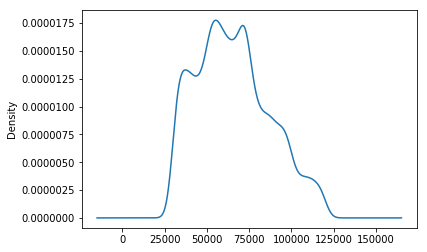

In [17]:

profile.income.plot.density()


In [18]:
profile.groupby('income').count().head()

,age,gender,id,memb_year,age_bin
income,,,,,
30000.0,88,88,88,88,88
31000.0,223,223,223,223,223
32000.0,216,216,216,216,216
33000.0,213,213,213,213,213
34000.0,199,199,199,199,199


In [19]:
#organize the income into buckets of a range for analysis purposes
def income_bin(income):
    if np.isnan(income):
        return 0
    return int(np.floor(income/10000))

In [20]:
profile['income_bin']=profile.income.apply(lambda x: income_bin(x))
profile.head()

,age,gender,id,income,memb_year,age_bin,income_bin
0,118,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017,11,0
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,5,11
2,118,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018,11,0
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,7,10
4,118,None,a03223e636434f42ac4c3df47e8bac43,NaN,2017,11,0


In [21]:
profile.info(),profile.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 7 columns):
age           17000 non-null int64
gender        14825 non-null object
id            17000 non-null object
income        14825 non-null float64
memb_year     17000 non-null int64
age_bin       17000 non-null int64
income_bin    17000 non-null int64
dtypes: float64(1), int64(4), object(2)
memory usage: 929.8+ KB


(None, (17000, 7))

In [22]:
#drop missing values
profile.dropna(inplace=True)
profile.shape

(14825, 7)

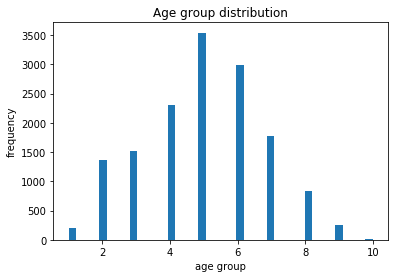

In [23]:
#Plot age group distribution
plt.hist(profile.age_bin, bins = 40,)
plt.title('Age group distribution')
plt.xlabel('age group')
plt.ylabel('frequency')
plt.show()

In [24]:
#Remove people whose age > 100. could be an outlier or a data mistake.
profile = profile[profile['age_bin']<10]
profile.shape

(14808, 7)

In [25]:
#how many customer's transcript details do we have.
len(transcript.person.unique().tolist())

17000

In [26]:
profile.shape

(14808, 7)

In [27]:
portfolio.columns

Index(['channels', 'difficulty', 'duration', 'id', 'offer_type', 'reward',
       'email_adv', 'mobile_adv', 'social_adv', 'web_adv', 'reward_ratio'],
      dtype='object')

In [28]:
profile.columns

Index(['age', 'gender', 'id', 'income', 'memb_year', 'age_bin', 'income_bin'], dtype='object')

In [29]:
transcript.columns

Index(['event', 'person', 'time', 'value'], dtype='object')

In [30]:
transcript.shape

(306534, 4)

In [31]:
#Convert gender into category column
profile['gender']=profile['gender'].astype('category',categories=['M','F','O'])
profile['gender']=profile.gender.cat.codes

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [32]:
# gender distribution in profile
profileGrpGender = profile.groupby('gender').count().reset_index()
profileGrpGender.rename({'age':'GenderCnt'},inplace=True,axis=1)
profileGrpGender = profileGrpGender[['gender','GenderCnt']]
profileGrpGender.head()

,gender,GenderCnt
0,0,8482
1,1,6115
2,2,211


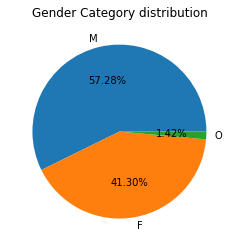

In [33]:
plt.pie(profileGrpGender.GenderCnt,labels = ['M','F','O'],autopct='%1.2f%%')
plt.title('Gender Category distribution')
plt.show()

In [34]:
#split data into 2 dataframes, offer_received and offer_completed

In [35]:
offer_received_data = transcript[transcript['event']=='offer received']
offer_received_data.shape

(76277, 4)

In [36]:
#Number of customers who received the offer.
offer_received_people=offer_received_data.person.unique().tolist()
len(offer_received_people)

16994

In [37]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [38]:
transcript = transcript[transcript['person'].isin(offer_received_people)]
transcript.shape

(306514, 4)

In [39]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [40]:
# remove all the transaction type records
transcript = transcript[transcript['event']!='transaction'] 
transcript.shape

(167581, 4)

In [41]:
# remove all the 'offer viewed' type records
transcript = transcript[transcript['event']!='offer viewed'] 
transcript.shape

(109856, 4)

In [42]:
#number of unique person's whose transcation records we have
len(transcript.person.unique())

16994

In [43]:
transcript_offer_received=transcript[transcript['event']=='offer received']
transcript_offer_completed = transcript[transcript['event']=='offer completed']
transcript_offer_received.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [44]:
transcript_offer_received.shape

(76277, 4)

In [45]:
transcript_offer_completed.head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [46]:
transcript_offer_completed.shape

(33579, 4)

In [47]:
transcript_offer_received['offerid'] = transcript_offer_received.value.apply(lambda x : x['offer id'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [48]:
transcript_offer_completed['offerid'] = transcript_offer_completed.value.apply(lambda x: x['offer_id'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [49]:
transcript_offer_received.head()

,event,person,time,value,offerid
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [50]:
transcript_offer_completed.head()

,event,person,time,value,offerid
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,fafdcd668e3743c1bb461111dcafc2a4
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,ae264e3637204a6fb9bb56bc8210ddfd
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,4d5c57ea9a6940dd891ad53e9dbe8da0


In [51]:
transcript_offer_completed[transcript_offer_completed['offerid'].isin(['3f207df678b143eea3cee63160fa8bed','5a8bc65990b245e5a138643cd4eb9837'])]

,event,person,time,value,offerid


In [52]:
#drop other columns which are not used
transcript_offer_received= transcript_offer_received.drop(['value','time','event'],axis=1)
transcript_offer_completed= transcript_offer_completed.drop(['value','time','event'],axis=1)

In [53]:
transcript_offer_received.columns=['person','id']
transcript_offer_received.head()

,person,id
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0


In [54]:
transcript_offer_completed.columns=['person','id']
transcript_offer_completed.head()

,person,id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0


In [55]:
transcript_offer_received=pd.merge(transcript_offer_received,portfolio,how='left',on='id')

In [56]:
transcript_offer_completed=pd.merge(transcript_offer_completed,portfolio,how='left',on='id')

In [57]:
transcript_offer_received.columns

Index(['person', 'id', 'channels', 'difficulty', 'duration', 'offer_type',
       'reward', 'email_adv', 'mobile_adv', 'social_adv', 'web_adv',
       'reward_ratio'],
      dtype='object')

In [58]:
transcript_offer_received.drop(['channels','difficulty','duration','reward','reward_ratio'],axis=1,inplace=True)
transcript_offer_received.head()

,person,id,offer_type,email_adv,mobile_adv,social_adv,web_adv
0,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1,1,0,1
1,a03223e636434f42ac4c3df47e8bac43,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1,0,0,1
2,e2127556f4f64592b11af22de27a7932,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,1,1
4,68617ca6246f4fbc85e91a2a49552598,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1,1,1,1


In [59]:
transcript_offer_completed.drop(['channels','difficulty','reward'],axis=1,inplace=True)
transcript_offer_completed.head()

,person,id,duration,offer_type,email_adv,mobile_adv,social_adv,web_adv,reward_ratio
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,2906b810c7d4411798c6938adc9daaa5,7,discount,1,1,0,1,0.2
1,fe97aa22dd3e48c8b143116a8403dd52,fafdcd668e3743c1bb461111dcafc2a4,10,discount,1,1,1,1,0.2
2,629fc02d56414d91bca360decdfa9288,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,bogo,1,1,0,1,1.0
3,676506bad68e4161b9bbaffeb039626b,ae264e3637204a6fb9bb56bc8210ddfd,7,bogo,1,1,1,0,1.0
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,4d5c57ea9a6940dd891ad53e9dbe8da0,5,bogo,1,1,1,1,1.0


In [60]:
rewardratio_countR = transcript_offer_received.groupby(['person']).mean()
rewardratio_countR.head()
#rewardratio_countR.iloc[:,0]

,email_adv,mobile_adv,social_adv,web_adv
person,,,,
0009655768c64bdeb2e877511632db8f,1.0,1.0,0.60,0.80
00116118485d4dfda04fdbaba9a87b5c,1.0,1.0,1.00,1.00
0011e0d4e6b944f998e987f904e8c1e5,1.0,0.8,0.40,0.80
0020c2b971eb4e9188eac86d93036a77,1.0,1.0,1.00,0.60
0020ccbbb6d84e358d3414a3ff76cffd,1.0,1.0,0.75,0.75


In [61]:
transcript_offer_received.columns,transcript_offer_received.shape

(Index(['person', 'id', 'offer_type', 'email_adv', 'mobile_adv', 'social_adv',
        'web_adv'],
       dtype='object'), (76277, 7))

In [62]:
#removing informational offers transaction
transcript_offer_received=transcript_offer_received[transcript_offer_received['offer_type']!='informational']
transcript_offer_received.shape

(61042, 7)

In [63]:
transcript_offer_received[transcript_offer_received['person']=='0009655768c64bdeb2e877511632db8f']

,person,id,offer_type,email_adv,mobile_adv,social_adv,web_adv
40835,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1,1,1,1
53578,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,discount,1,1,1,1
66269,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,discount,1,1,0,1


In [65]:
offer_received_count = transcript_offer_received.groupby(['person']).agg({'id':'count'}).reset_index()
offer_received_count.columns=['person','offerRcvdCnt']
offer_received_count.head()

,person,offerRcvdCnt
0,0009655768c64bdeb2e877511632db8f,3
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,3
3,0020c2b971eb4e9188eac86d93036a77,4
4,0020ccbbb6d84e358d3414a3ff76cffd,3


In [66]:
#Compute the number of offers received by a person
offer_received_count.columns=['person','offerRcvdCnt']
offer_received_count.head()

,person,offerRcvdCnt
0,0009655768c64bdeb2e877511632db8f,3
1,00116118485d4dfda04fdbaba9a87b5c,2
2,0011e0d4e6b944f998e987f904e8c1e5,3
3,0020c2b971eb4e9188eac86d93036a77,4
4,0020ccbbb6d84e358d3414a3ff76cffd,3


In [67]:
transcript_offer_completed.columns

Index(['person', 'id', 'duration', 'offer_type', 'email_adv', 'mobile_adv',
       'social_adv', 'web_adv', 'reward_ratio'],
      dtype='object')

In [68]:
#compute the number of offers completed by the person along with the avg reeward-to-difficulty ratio and avg duration of every person who completed the offer.
offer_completed_count = transcript_offer_completed.groupby(['person']).agg({'id':'count','duration':np.mean,'reward_ratio':np.mean}).reset_index()
offer_completed_count.columns=['person','offerCompletedCnt','rr_avg','duration_avg']
offer_completed_count.head()

,person,offerCompletedCnt,rr_avg,duration_avg
0,0009655768c64bdeb2e877511632db8f,3,7.333333,0.466667
1,0011e0d4e6b944f998e987f904e8c1e5,3,8.000000,0.559524
2,0020c2b971eb4e9188eac86d93036a77,3,8.333333,0.466667
3,0020ccbbb6d84e358d3414a3ff76cffd,3,6.333333,0.809524
4,003d66b6608740288d6cc97a6903f4f0,3,10.000000,0.216667


In [69]:
#merge the offers received and offers completed dataset
offerResponse = pd.merge(offer_received_count,offer_completed_count,on='person',how='left')
offerResponse.head()

,person,offerRcvdCnt,offerCompletedCnt,rr_avg,duration_avg
0,0009655768c64bdeb2e877511632db8f,3,3.0,7.333333,0.466667
1,00116118485d4dfda04fdbaba9a87b5c,2,NaN,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,3,3.0,8.000000,0.559524
3,0020c2b971eb4e9188eac86d93036a77,4,3.0,8.333333,0.466667
4,0020ccbbb6d84e358d3414a3ff76cffd,3,3.0,6.333333,0.809524


In [70]:
offerResponse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16928 entries, 0 to 16927
Data columns (total 5 columns):
person               16928 non-null object
offerRcvdCnt         16928 non-null int64
offerCompletedCnt    12774 non-null float64
rr_avg               12774 non-null float64
duration_avg         12774 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 793.5+ KB


In [71]:
offerResponse[offerResponse['offerRcvdCnt']==0]

,person,offerRcvdCnt,offerCompletedCnt,rr_avg,duration_avg


In [72]:
offerResponse.fillna(0,inplace=True)
offerResponse.head()

,person,offerRcvdCnt,offerCompletedCnt,rr_avg,duration_avg
0,0009655768c64bdeb2e877511632db8f,3,3.0,7.333333,0.466667
1,00116118485d4dfda04fdbaba9a87b5c,2,0.0,0.000000,0.000000
2,0011e0d4e6b944f998e987f904e8c1e5,3,3.0,8.000000,0.559524
3,0020c2b971eb4e9188eac86d93036a77,4,3.0,8.333333,0.466667
4,0020ccbbb6d84e358d3414a3ff76cffd,3,3.0,6.333333,0.809524


In [73]:
#Compute column offerCompletionRatio
offerResponse['offerCompletionRatio']=offerResponse['offerCompletedCnt']/offerResponse['offerRcvdCnt']
offerResponse.head()

,person,offerRcvdCnt,offerCompletedCnt,rr_avg,duration_avg,offerCompletionRatio
0,0009655768c64bdeb2e877511632db8f,3,3.0,7.333333,0.466667,1.00
1,00116118485d4dfda04fdbaba9a87b5c,2,0.0,0.000000,0.000000,0.00
2,0011e0d4e6b944f998e987f904e8c1e5,3,3.0,8.000000,0.559524,1.00
3,0020c2b971eb4e9188eac86d93036a77,4,3.0,8.333333,0.466667,0.75
4,0020ccbbb6d84e358d3414a3ff76cffd,3,3.0,6.333333,0.809524,1.00


In [74]:
offerResponse.shape,offerResponse.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16928 entries, 0 to 16927
Data columns (total 6 columns):
person                  16928 non-null object
offerRcvdCnt            16928 non-null int64
offerCompletedCnt       16928 non-null float64
rr_avg                  16928 non-null float64
duration_avg            16928 non-null float64
offerCompletionRatio    16928 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 925.8+ KB


((16928, 6), None)

In [75]:
#Drop the columns as we computed new column based on these values
offerResponse.drop(columns=['offerRcvdCnt','offerCompletedCnt'],inplace=True)
offerResponse.head()

,person,rr_avg,duration_avg,offerCompletionRatio
0,0009655768c64bdeb2e877511632db8f,7.333333,0.466667,1.00
1,00116118485d4dfda04fdbaba9a87b5c,0.000000,0.000000,0.00
2,0011e0d4e6b944f998e987f904e8c1e5,8.000000,0.559524,1.00
3,0020c2b971eb4e9188eac86d93036a77,8.333333,0.466667,0.75
4,0020ccbbb6d84e358d3414a3ff76cffd,6.333333,0.809524,1.00


In [76]:
#Rename columns in order to join with profile dataframe
offerResponse.rename({'person':'id'},inplace=True,axis=1)
offerResponse.head()

,id,rr_avg,duration_avg,offerCompletionRatio
0,0009655768c64bdeb2e877511632db8f,7.333333,0.466667,1.00
1,00116118485d4dfda04fdbaba9a87b5c,0.000000,0.000000,0.00
2,0011e0d4e6b944f998e987f904e8c1e5,8.000000,0.559524,1.00
3,0020c2b971eb4e9188eac86d93036a77,8.333333,0.466667,0.75
4,0020ccbbb6d84e358d3414a3ff76cffd,6.333333,0.809524,1.00


In [77]:
profile.head()

,age,gender,id,income,memb_year,age_bin,income_bin
1,55,1,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,5,11
3,75,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,7,10
5,68,0,e2127556f4f64592b11af22de27a7932,70000.0,2018,6,7
8,65,0,389bc3fa690240e798340f5a15918d5c,53000.0,2018,6,5
12,58,0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,5,5


In [78]:
profile.describe()

,age,gender,income,memb_year,age_bin,income_bin
count,14808.000000,14808.000000,14808.000000,14808.000000,14808.000000,14808.000000
mean,54.340829,0.441451,65394.313884,2016.620138,4.984873,6.102917
std,17.323921,0.524489,21595.072904,1.198429,1.756283,2.149871
min,18.000000,0.000000,30000.000000,2013.000000,1.000000,3.000000
25%,42.000000,0.000000,49000.000000,2016.000000,4.000000,4.000000
50%,55.000000,0.000000,64000.000000,2017.000000,5.000000,6.000000
75%,66.000000,1.000000,80000.000000,2017.000000,6.000000,8.000000
max,99.000000,2.000000,120000.000000,2018.000000,9.000000,12.000000


In [79]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14808 entries, 1 to 16999
Data columns (total 7 columns):
age           14808 non-null int64
gender        14808 non-null int8
id            14808 non-null object
income        14808 non-null float64
memb_year     14808 non-null int64
age_bin       14808 non-null int64
income_bin    14808 non-null int64
dtypes: float64(1), int64(4), int8(1), object(1)
memory usage: 824.3+ KB


In [80]:
transcript[transcript['person']=='00116118485d4dfda04fdbaba9a87b5c']

,event,person,time,value
56475,offer received,00116118485d4dfda04fdbaba9a87b5c,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
248359,offer received,00116118485d4dfda04fdbaba9a87b5c,576,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}


In [81]:
profile[profile['id']=='00116118485d4dfda04fdbaba9a87b5c']

,age,gender,id,income,memb_year,age_bin,income_bin


In [82]:
#Merge offer details of person with profile details
offer_profile = pd.merge(offerResponse,profile,how='left',on='id')
offer_profile.head()

,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin
0,0009655768c64bdeb2e877511632db8f,7.333333,0.466667,1.00,33.0,0.0,72000.0,2017.0,3.0,7.0
1,00116118485d4dfda04fdbaba9a87b5c,0.000000,0.000000,0.00,NaN,NaN,NaN,NaN,NaN,NaN
2,0011e0d4e6b944f998e987f904e8c1e5,8.000000,0.559524,1.00,40.0,2.0,57000.0,2018.0,4.0,5.0
3,0020c2b971eb4e9188eac86d93036a77,8.333333,0.466667,0.75,59.0,1.0,90000.0,2016.0,5.0,9.0
4,0020ccbbb6d84e358d3414a3ff76cffd,6.333333,0.809524,1.00,24.0,1.0,60000.0,2016.0,2.0,6.0


In [83]:
offer_profile.shape

(16928, 10)

In [84]:
offer_profile.dropna(inplace=True)
offer_profile.head()

,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin
0,0009655768c64bdeb2e877511632db8f,7.333333,0.466667,1.00,33.0,0.0,72000.0,2017.0,3.0,7.0
2,0011e0d4e6b944f998e987f904e8c1e5,8.000000,0.559524,1.00,40.0,2.0,57000.0,2018.0,4.0,5.0
3,0020c2b971eb4e9188eac86d93036a77,8.333333,0.466667,0.75,59.0,1.0,90000.0,2016.0,5.0,9.0
4,0020ccbbb6d84e358d3414a3ff76cffd,6.333333,0.809524,1.00,24.0,1.0,60000.0,2016.0,2.0,6.0
5,003d66b6608740288d6cc97a6903f4f0,10.000000,0.216667,1.00,26.0,1.0,73000.0,2017.0,2.0,7.0


In [85]:
offer_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14747 entries, 0 to 16927
Data columns (total 10 columns):
id                      14747 non-null object
rr_avg                  14747 non-null float64
duration_avg            14747 non-null float64
offerCompletionRatio    14747 non-null float64
age                     14747 non-null float64
gender                  14747 non-null float64
income                  14747 non-null float64
memb_year               14747 non-null float64
age_bin                 14747 non-null float64
income_bin              14747 non-null float64
dtypes: float64(9), object(1)
memory usage: 1.2+ MB


In [86]:
offer_profile.shape

(14747, 10)

In [87]:
offer_profile.columns

Index(['id', 'rr_avg', 'duration_avg', 'offerCompletionRatio', 'age', 'gender',
       'income', 'memb_year', 'age_bin', 'income_bin'],
      dtype='object')

In [88]:
#based on percentage of offer completion of a person, compute the final outcome variable
def yes_or_no(row,compute_column,percentage):
    if row[compute_column] == -1.0:
        return -1
    elif row[compute_column]>=percentage:
        return 1
    return 0

In [170]:
#Create the label/output column
offer_profile['offer_completed']=offer_profile.apply(lambda x: yes_or_no(x,'offerCompletionRatio',0.6), axis=1)
offer_profile.head()

KeyError: ('offerCompletionRatio', 'occurred at index 0')

In [90]:
offer_profile.shape

(14747, 11)

In [91]:
offer_profile.groupby('offer_completed').count()

,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin
offer_completed,,,,,,,,,,
0,6214,6214,6214,6214,6214,6214,6214,6214,6214,6214
1,8533,8533,8533,8533,8533,8533,8533,8533,8533,8533


In [ ]:
#about 42% of people avail the offer atleast 80% of time.
#about 48% of people avail the offer atleast 75% of time.
#about 58% of people avail the offer atleast 60% of time.
#about 67% of people avail the offer atleast 50% of time.

In [ ]:
#discount_alone.groupby('discount').count()

In [ ]:
#about 53.6% of people avail the discount offer atleast 80% of time.
#about 70% of people avail the discount offer atleast 50% of the time

In [92]:
offer_profile[offer_profile['offer_completed']==1].groupby('gender').count()

,id,rr_avg,duration_avg,offerCompletionRatio,age,income,memb_year,age_bin,income_bin,offer_completed
gender,,,,,,,,,,
0.0,4158,4158,4158,4158,4158,4158,4158,4158,4158,4158
1.0,4240,4240,4240,4240,4240,4240,4240,4240,4240,4240
2.0,135,135,135,135,135,135,135,135,135,135


In [93]:
offer_profile[offer_profile['offer_completed']==1].describe()

,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin,offer_completed
count,8533.000000,8533.000000,8533.000000,8533.000000,8533.000000,8533.000000,8533.000000,8533.000000,8533.000000,8533.0
mean,7.319462,0.619112,0.898519,56.238955,0.528536,70543.419665,2016.394820,5.173444,6.611977,1.0
std,1.071886,0.222531,0.142312,16.583879,0.529963,21555.375658,1.101976,1.682251,2.145227,0.0
min,5.000000,0.200000,0.600000,18.000000,0.000000,30000.000000,2013.000000,1.000000,3.000000,1.0
25%,6.500000,0.466667,0.750000,46.000000,0.000000,54000.000000,2016.000000,4.000000,5.000000,1.0
50%,7.250000,0.612500,1.000000,57.000000,1.000000,70000.000000,2017.000000,5.000000,7.000000,1.0
75%,8.000000,0.750000,1.000000,67.000000,1.000000,86000.000000,2017.000000,6.000000,8.000000,1.0
max,10.000000,1.000000,1.000000,99.000000,2.000000,120000.000000,2018.000000,9.000000,12.000000,1.0


In [94]:
offer_profile_yes = offer_profile[offer_profile['offer_completed']==1]
offer_profile_yes.head()

,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin,offer_completed
0,0009655768c64bdeb2e877511632db8f,7.333333,0.466667,1.00,33.0,0.0,72000.0,2017.0,3.0,7.0,1
2,0011e0d4e6b944f998e987f904e8c1e5,8.000000,0.559524,1.00,40.0,2.0,57000.0,2018.0,4.0,5.0,1
3,0020c2b971eb4e9188eac86d93036a77,8.333333,0.466667,0.75,59.0,1.0,90000.0,2016.0,5.0,9.0,1
4,0020ccbbb6d84e358d3414a3ff76cffd,6.333333,0.809524,1.00,24.0,1.0,60000.0,2016.0,2.0,6.0,1
5,003d66b6608740288d6cc97a6903f4f0,10.000000,0.216667,1.00,26.0,1.0,73000.0,2017.0,2.0,7.0,1


In [95]:
offer_profile.shape,offer_profile_yes.shape

((14747, 11), (8533, 11))

In [96]:
offer_profile.columns

Index(['id', 'rr_avg', 'duration_avg', 'offerCompletionRatio', 'age', 'gender',
       'income', 'memb_year', 'age_bin', 'income_bin', 'offer_completed'],
      dtype='object')

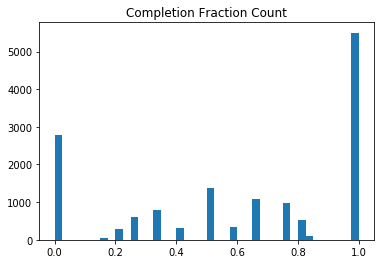

In [97]:
#Histogram of offer completed fraction
plt.hist(offer_profile['offerCompletionRatio'], bins=40)
plt.title('Completion Fraction Count')
plt.show()

In [104]:
offer_profile.head()

,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin,offer_completed
0,0009655768c64bdeb2e877511632db8f,7.333333,0.466667,1.00,33.0,0.0,72000.0,2017.0,3.0,7.0,1
2,0011e0d4e6b944f998e987f904e8c1e5,8.000000,0.559524,1.00,40.0,2.0,57000.0,2018.0,4.0,5.0,1
3,0020c2b971eb4e9188eac86d93036a77,8.333333,0.466667,0.75,59.0,1.0,90000.0,2016.0,5.0,9.0,1
4,0020ccbbb6d84e358d3414a3ff76cffd,6.333333,0.809524,1.00,24.0,1.0,60000.0,2016.0,2.0,6.0,1
5,003d66b6608740288d6cc97a6903f4f0,10.000000,0.216667,1.00,26.0,1.0,73000.0,2017.0,2.0,7.0,1


In [105]:
offer_profile_yes_genderct = offer_profile_yes.groupby('gender').count().reset_index()
offer_profile_yes_genderct

,gender,id,rr_avg,duration_avg,offerCompletionRatio,age,income,memb_year,age_bin,income_bin,offer_completed
0,0.0,4158,4158,4158,4158,4158,4158,4158,4158,4158,4158
1,1.0,4240,4240,4240,4240,4240,4240,4240,4240,4240,4240
2,2.0,135,135,135,135,135,135,135,135,135,135


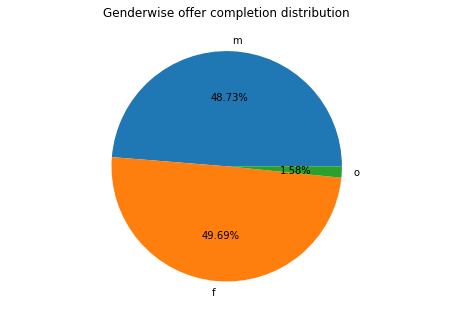

In [106]:
#Genderwise offer completion distribution
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(offer_profile_yes_genderct.id, labels = ['m','f','o'],autopct='%1.2f%%')
plt.title("Genderwise offer completion distribution")
plt.show()

In [107]:
male_offer = offer_profile[offer_profile['gender']==0]
male_offer.groupby('offer_completed').count()

,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin
offer_completed,,,,,,,,,,
0,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290
1,4158,4158,4158,4158,4158,4158,4158,4158,4158,4158


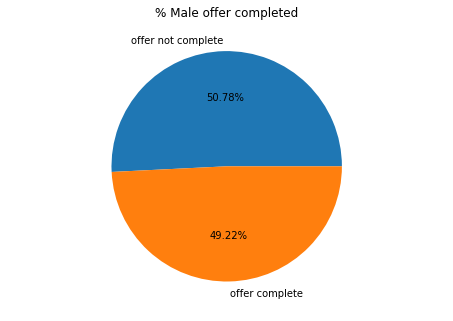

In [108]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(male_offer.groupby('offer_completed').count().reset_index().id, 
       labels = ['offer not complete','offer complete']
       ,autopct='%1.2f%%')
plt.title('% Male offer completed')
plt.show()

In [109]:
female_offer = offer_profile[offer_profile['gender']==1]
female_offer.groupby('offer_completed').count()

,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin
offer_completed,,,,,,,,,,
0,1849,1849,1849,1849,1849,1849,1849,1849,1849,1849
1,4240,4240,4240,4240,4240,4240,4240,4240,4240,4240


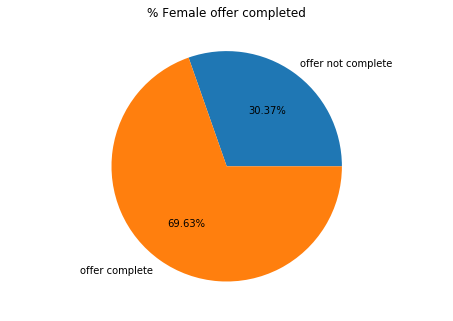

In [110]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(female_offer.groupby('offer_completed').count().iloc[:,0], labels = ['offer not complete','offer complete'],autopct='%1.2f%%',)
plt.title('% Female offer completed')
plt.show()

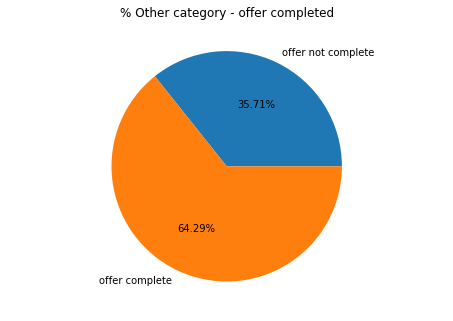

In [111]:
transg_offer = offer_profile[offer_profile['gender']==2]
transg_offer.groupby('offer_completed').count()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(transg_offer.groupby('offer_completed').count().iloc[:,0], labels =['offer not complete','offer complete'],autopct='%1.2f%%')
plt.title('% Other category - offer completed')

plt.show()

In [112]:
## membership year analysis

In [113]:
offer_profile[offer_profile['offer_completed']==1].groupby('memb_year').count()

,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,age_bin,income_bin,offer_completed
memb_year,,,,,,,,,,
2013.0,140,140,140,140,140,140,140,140,140,140
2014.0,325,325,325,325,325,325,325,325,325,325
2015.0,1155,1155,1155,1155,1155,1155,1155,1155,1155,1155
2016.0,2510,2510,2510,2510,2510,2510,2510,2510,2510,2510
2017.0,3212,3212,3212,3212,3212,3212,3212,3212,3212,3212
2018.0,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191


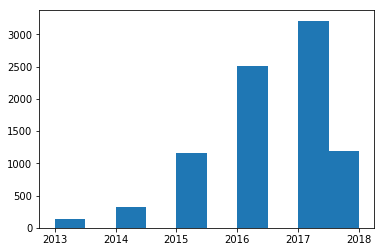

In [114]:
plt.hist(offer_profile[offer_profile['offer_completed']==1].memb_year)
plt.show()

In [115]:
#statistics of female who completed the offer.
female_offer[female_offer['offer_completed']==1].describe()

,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin,offer_completed
count,4240.000000,4240.000000,4240.000000,4240.000000,4240.0,4240.000000,4240.000000,4240.000000,4240.000000,4240.0
mean,7.298911,0.625105,0.904937,58.068868,1.0,73766.037736,2016.470283,5.357075,6.930189,1.0
std,1.064016,0.220213,0.138574,16.439140,0.0,21906.672821,1.010940,1.671923,2.174686,0.0
min,5.000000,0.200000,0.600000,18.000000,1.0,30000.000000,2013.000000,1.000000,3.000000,1.0
25%,6.500000,0.469643,0.750000,49.000000,1.0,57000.000000,2016.000000,4.000000,5.000000,1.0
50%,7.250000,0.612500,1.000000,58.000000,1.0,73000.000000,2017.000000,5.000000,7.000000,1.0
75%,8.000000,0.750000,1.000000,69.000000,1.0,90000.000000,2017.000000,6.000000,9.000000,1.0
max,10.000000,1.000000,1.000000,99.000000,1.0,120000.000000,2018.000000,9.000000,12.000000,1.0


In [116]:
# statistics of all female who received the offer.
female_offer.describe()

,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin,offer_completed
count,6089.000000,6089.000000,6089.000000,6089.000000,6089.0,6089.000000,6089.000000,6089.000000,6089.000000,6089.000000
mean,6.451642,0.548909,0.703972,57.446214,1.0,71315.651174,2016.633602,5.294137,6.691575,0.696338
std,2.603311,0.307401,0.345706,16.782380,0.0,22335.908133,1.074245,1.704819,2.218175,0.459876
min,0.000000,0.000000,0.000000,18.000000,1.0,30000.000000,2013.000000,1.000000,3.000000,0.000000
25%,6.000000,0.314286,0.500000,48.000000,1.0,54000.000000,2016.000000,4.000000,5.000000,0.000000
50%,7.000000,0.600000,0.800000,58.000000,1.0,71000.000000,2017.000000,5.000000,7.000000,1.000000
75%,8.000000,0.750000,1.000000,69.000000,1.0,88000.000000,2017.000000,6.000000,8.000000,1.000000
max,10.000000,1.000000,1.000000,99.000000,1.0,120000.000000,2018.000000,9.000000,12.000000,1.000000


In [117]:
#statistics of male who completed the offer.
male_offer[male_offer['offer_completed']==1].describe()

,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,income_bin,offer_completed
count,4158.000000,4158.000000,4158.000000,4158.00000,4158.0,4158.000000,4158.000000,4158.000000,4158.000000,4158.0
mean,7.339137,0.612694,0.890673,54.40885,0.0,67409.331409,2016.313372,4.990620,6.302068,1.0
std,1.077382,0.224809,0.146104,16.57732,0.0,20784.906662,1.182492,1.678562,2.075702,0.0
min,5.000000,0.200000,0.600000,18.00000,0.0,30000.000000,2013.000000,1.000000,3.000000,1.0
25%,6.500000,0.466667,0.750000,43.00000,0.0,52000.000000,2016.000000,4.000000,5.000000,1.0
50%,7.250000,0.600000,1.000000,55.00000,0.0,66000.000000,2016.000000,5.000000,6.000000,1.0
75%,8.000000,0.750000,1.000000,66.00000,0.0,81000.000000,2017.000000,6.000000,8.000000,1.0
max,10.000000,1.000000,1.000000,99.00000,0.0,120000.000000,2018.000000,9.000000,12.000000,1.0


In [118]:
male_offer.income.mean()

61202.17803030303

In [119]:
male_offer[male_offer['offer_completed']==1].income.mean()

67409.33140933141

In [120]:
male_offer.groupby('income_bin').count()

,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,offer_completed
income_bin,,,,,,,,,,
3.0,1351,1351,1351,1351,1351,1351,1351,1351,1351,1351
4.0,1287,1287,1287,1287,1287,1287,1287,1287,1287,1287
5.0,1663,1663,1663,1663,1663,1663,1663,1663,1663,1663
6.0,1441,1441,1441,1441,1441,1441,1441,1441,1441,1441
7.0,1209,1209,1209,1209,1209,1209,1209,1209,1209,1209
8.0,594,594,594,594,594,594,594,594,594,594
9.0,555,555,555,555,555,555,555,555,555,555
10.0,173,173,173,173,173,173,173,173,173,173
11.0,169,169,169,169,169,169,169,169,169,169


In [121]:
male_offer[male_offer['offer_completed'] ==1].groupby('income_bin').count()

,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,offer_completed
income_bin,,,,,,,,,,
3.0,426,426,426,426,426,426,426,426,426,426
4.0,418,418,418,418,418,418,418,418,418,418
5.0,746,746,746,746,746,746,746,746,746,746
6.0,715,715,715,715,715,715,715,715,715,715
7.0,715,715,715,715,715,715,715,715,715,715
8.0,435,435,435,435,435,435,435,435,435,435
9.0,427,427,427,427,427,427,427,427,427,427
10.0,135,135,135,135,135,135,135,135,135,135
11.0,136,136,136,136,136,136,136,136,136,136


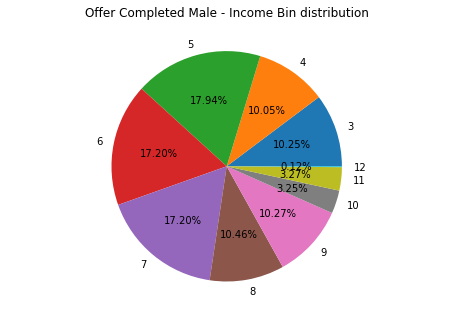

In [122]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(male_offer[male_offer['offer_completed'] ==1].groupby('income_bin').count().iloc[:,0], labels =[3,4,5,6,7,8,9,10,11,12],autopct='%1.2f%%')
plt.title('Offer Completed Male - Income Bin distribution')
plt.show()

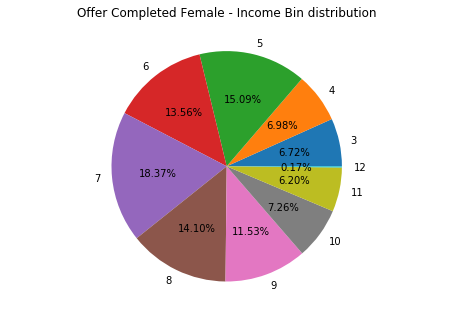

In [123]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(female_offer[female_offer['offer_completed'] ==1].groupby('income_bin').count().iloc[:,0], labels =[3,4,5,6,7,8,9,10,11,12],autopct='%1.2f%%')
plt.title('Offer Completed Female - Income Bin distribution')
plt.show()

In [ ]:
offer_profile.columns

In [124]:
offer_profile[offer_profile['offer_completed']==1].groupby('income_bin').count().reset_index()

,income_bin,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,age_bin,offer_completed
0,3.0,727,727,727,727,727,727,727,727,727,727
1,4.0,720,720,720,720,720,720,720,720,720,720
2,5.0,1415,1415,1415,1415,1415,1415,1415,1415,1415,1415
3,6.0,1316,1316,1316,1316,1316,1316,1316,1316,1316,1316
4,7.0,1517,1517,1517,1517,1517,1517,1517,1517,1517,1517
5,8.0,1052,1052,1052,1052,1052,1052,1052,1052,1052,1052
6,9.0,930,930,930,930,930,930,930,930,930,930
7,10.0,445,445,445,445,445,445,445,445,445,445
8,11.0,399,399,399,399,399,399,399,399,399,399
9,12.0,12,12,12,12,12,12,12,12,12,12


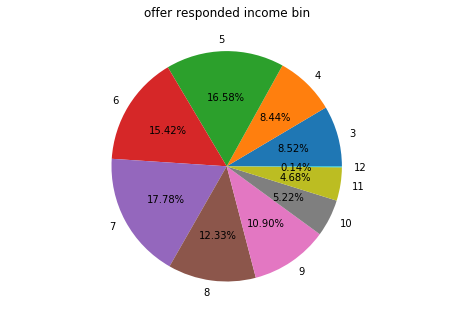

In [125]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(offer_profile[offer_profile['offer_completed']==1].groupby('income_bin').count().reset_index().id, labels =[3,4,5,6,7,8,9,10,11,12],autopct='%1.2f%%')
plt.title('offer responded income bin')
plt.show()

In [126]:
offer_profile[offer_profile['offer_completed']==1].groupby('age_bin').count().reset_index()

,age_bin,id,rr_avg,duration_avg,offerCompletionRatio,age,gender,income,memb_year,income_bin,offer_completed
0,1.0,77,77,77,77,77,77,77,77,77,77
1,2.0,579,579,579,579,579,579,579,579,579,579
2,3.0,762,762,762,762,762,762,762,762,762,762
3,4.0,1254,1254,1254,1254,1254,1254,1254,1254,1254,1254
4,5.0,2225,2225,2225,2225,2225,2225,2225,2225,2225,2225
5,6.0,1825,1825,1825,1825,1825,1825,1825,1825,1825,1825
6,7.0,1109,1109,1109,1109,1109,1109,1109,1109,1109,1109
7,8.0,548,548,548,548,548,548,548,548,548,548
8,9.0,154,154,154,154,154,154,154,154,154,154


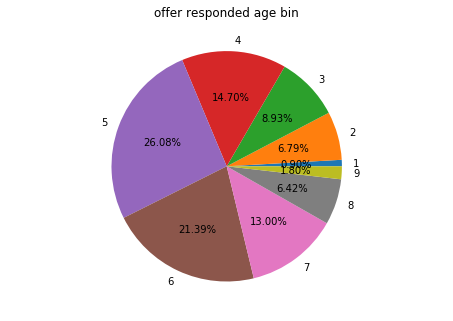

In [127]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(offer_profile[offer_profile['offer_completed']==1].groupby('age_bin').count().reset_index().id, labels =[1,2,3,4,5,6,7,8,9],autopct='%1.2f%%')
plt.title('offer responded age bin')
plt.show()

In [ ]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.axis('equal')

# ax.pie(discount_alone[discount_alone['bogo']==1].groupby('age_bin').count().iloc[:,0], labels =[3,4,5,6,7,8,9,10,11,12],autopct='%1.2f%%')
# plt.title('discount responded age bin')
# plt.show()

In [ ]:
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.axis('equal')

# ax.pie(discount_alone[discount_alone['discount']==1].groupby('income_bin').count().iloc[:,0], labels =[3,4,5,6,7,8,9,10,11,12],autopct='%1.2f%%')
# plt.title('discount responded income bin')
# plt.show()

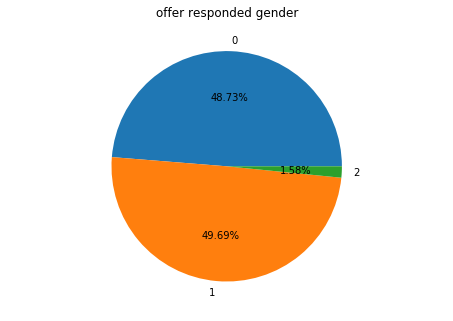

In [128]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(offer_profile[offer_profile['offer_completed']==1].groupby('gender').count().reset_index().id, labels =[0,1,2],autopct='%1.2f%%')
plt.title('offer responded gender')
plt.show()

In [129]:
offer_profile.columns

Index(['id', 'rr_avg', 'duration_avg', 'offerCompletionRatio', 'age', 'gender',
       'income', 'memb_year', 'age_bin', 'income_bin', 'offer_completed'],
      dtype='object')

In [130]:
offer_profile.drop(['age_bin','income_bin','offerCompletionRatio'],axis=1,inplace=True)

In [131]:
#Correlation between columns
offer_profile.corr()

,rr_avg,duration_avg,age,gender,income,memb_year,offer_completed
rr_avg,1.000000,0.480373,0.088567,0.132752,0.209319,-0.232033,0.523350
duration_avg,0.480373,1.000000,0.087567,0.130505,0.201344,-0.146290,0.431860
age,0.088567,0.087567,1.000000,0.140465,0.306538,-0.014115,0.128090
gender,0.132752,0.130505,0.140465,1.000000,0.209637,0.013173,0.194748
income,0.209319,0.201344,0.306538,0.209637,1.000000,-0.029107,0.278775
memb_year,-0.232033,-0.146290,-0.014115,0.013173,-0.029107,1.000000,-0.220889
offer_completed,0.523350,0.431860,0.128090,0.194748,0.278775,-0.220889,1.000000


In [132]:
offer_profile.shape

(14747, 8)

In [133]:
offer_profile.columns

Index(['id', 'rr_avg', 'duration_avg', 'age', 'gender', 'income', 'memb_year',
       'offer_completed'],
      dtype='object')

In [ ]:
# DONT DO THIS AS WE WILL LOSE ALL THE PEOPLE WHO DID NOT COMPLETE EVEN 1 OFFER
# final_profile.dropna(inplace=True)
# final_profile.shape

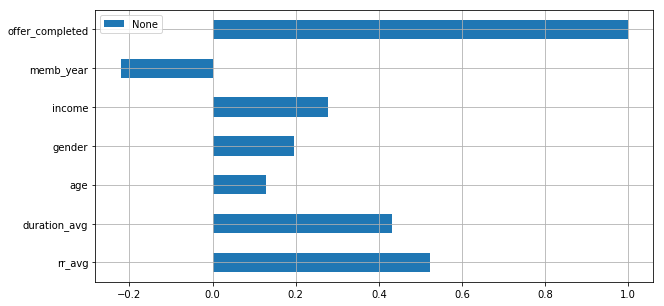

In [134]:
#Correlation of features with the label
offer_profile.corrwith(offer_profile['offer_completed']).plot(kind='barh',figsize=[10,5], legend=True,grid=True)


In [135]:
offer_profile[offer_profile['offer_completed']==0].shape

(6214, 8)

In [136]:
profile.columns

Index(['age', 'gender', 'id', 'income', 'memb_year', 'age_bin', 'income_bin'], dtype='object')

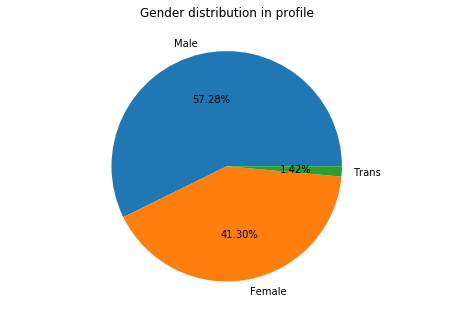

In [137]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(profile.groupby('gender').count().iloc[:,0],labels=['Male','Female','Trans'], autopct='%1.2f%%',)
plt.title('Gender distribution in profile')
plt.show()

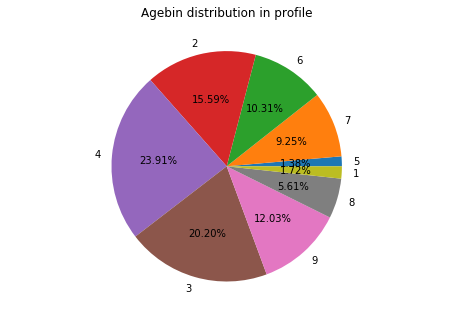

In [138]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(profile.groupby('age_bin').count().iloc[:,0],labels=profile.age_bin.unique(), autopct='%1.2f%%',)
plt.title('Agebin distribution in profile')
plt.show()

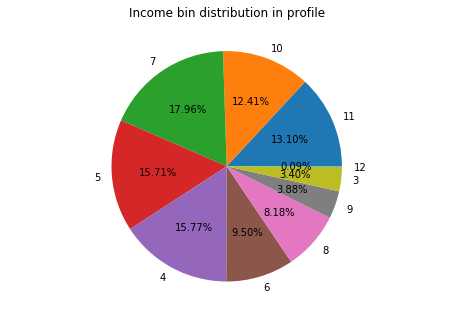

In [139]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.pie(profile.groupby('income_bin').count().iloc[:,0],labels=profile.income_bin.unique(), autopct='%1.2f%%',)
plt.title('Income bin distribution in profile')
plt.show()

In [140]:
offer_profile.head()

,id,rr_avg,duration_avg,age,gender,income,memb_year,offer_completed
0,0009655768c64bdeb2e877511632db8f,7.333333,0.466667,33.0,0.0,72000.0,2017.0,1
2,0011e0d4e6b944f998e987f904e8c1e5,8.000000,0.559524,40.0,2.0,57000.0,2018.0,1
3,0020c2b971eb4e9188eac86d93036a77,8.333333,0.466667,59.0,1.0,90000.0,2016.0,1
4,0020ccbbb6d84e358d3414a3ff76cffd,6.333333,0.809524,24.0,1.0,60000.0,2016.0,1
5,003d66b6608740288d6cc97a6903f4f0,10.000000,0.216667,26.0,1.0,73000.0,2017.0,1


In [141]:
offer_profile.drop('id',inplace=True,axis=1)


In [142]:
from sklearn.cluster import KMeans

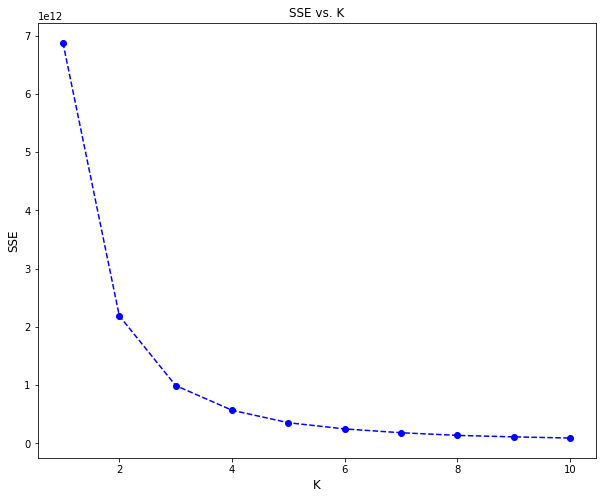

In [143]:
scores = []

for k in range(1,11):
    kmeans = KMeans(k)
    
    model = kmeans.fit(offer_profile)
    
    scores.append(abs(model.score(offer_profile)))
    
plt.figure(figsize=(10,8))
plt.plot(range(1,11), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K', fontsize = 12);
plt.ylabel('SSE', fontsize = 12);
plt.title('SSE vs. K', fontsize = 12);

In [144]:
import sagemaker
import boto3
from sagemaker import get_execution_role

In [145]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# S3 bucket name
bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-ap-south-1-963996037228'

In [146]:
import seaborn as sns

<Figure size 720x576 with 0 Axes>

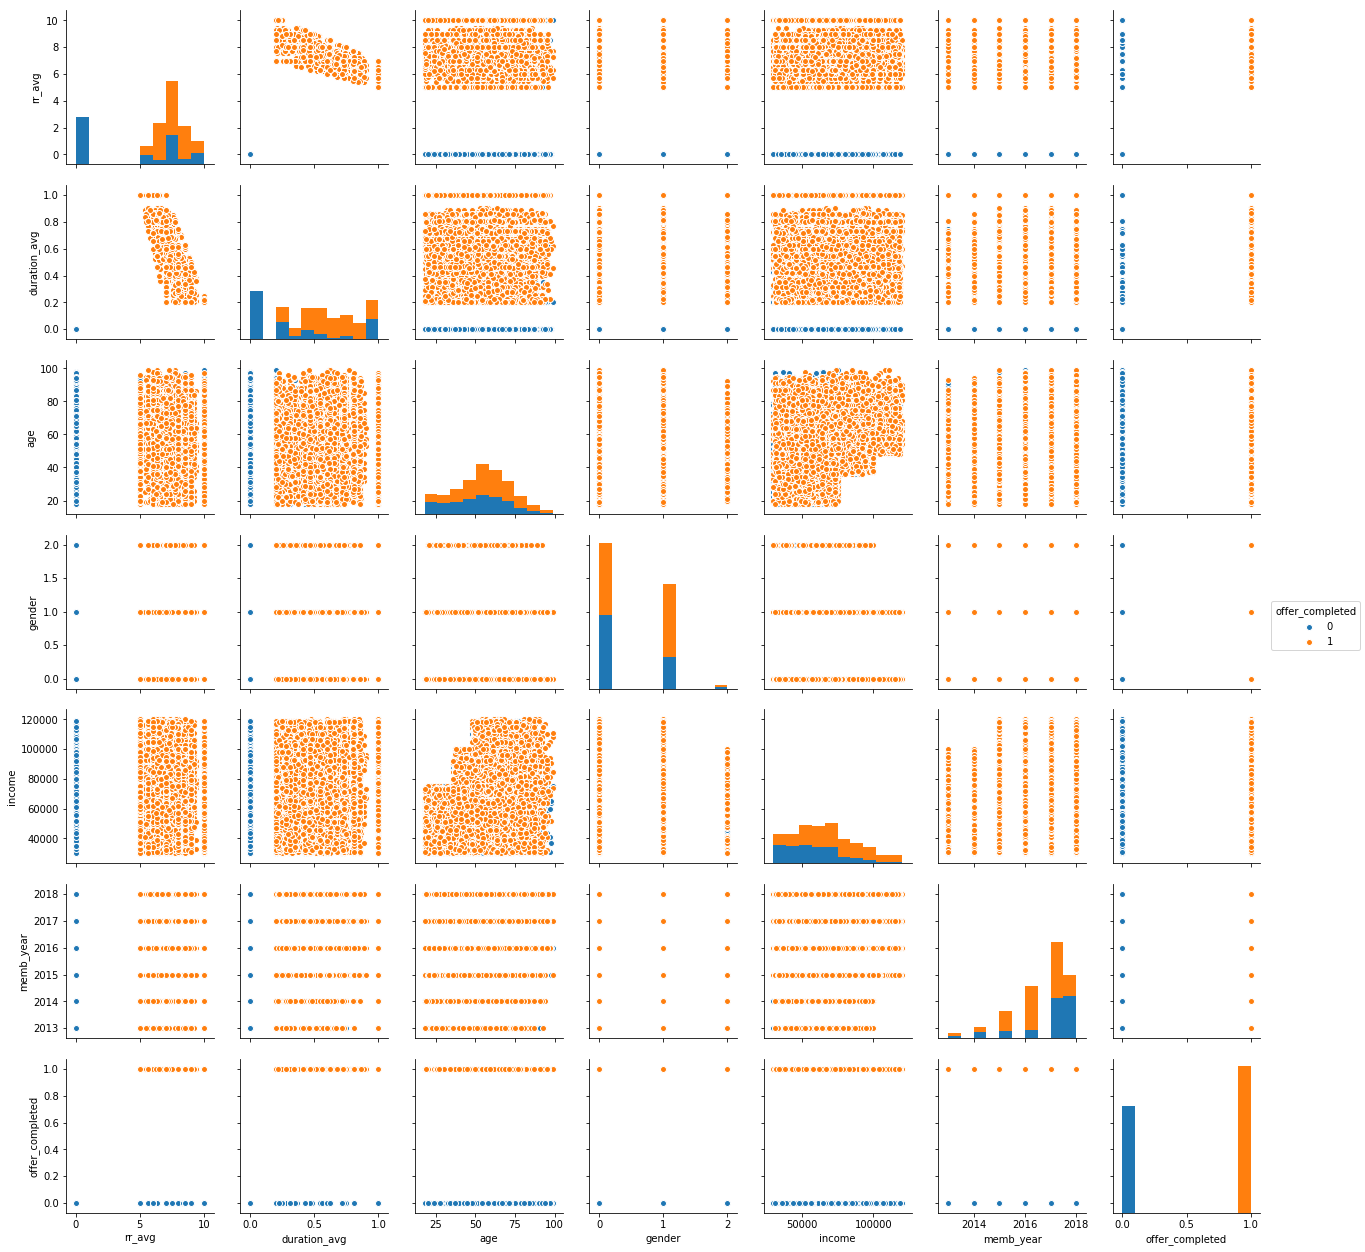

In [147]:
plt.figure(figsize= (10,8))
sns.pairplot(offer_profile, hue='offer_completed');

In [148]:
offer_profile.columns

Index(['rr_avg', 'duration_avg', 'age', 'gender', 'income', 'memb_year',
       'offer_completed'],
      dtype='object')

In [149]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,recall_score,f1_score

In [150]:
y = offer_profile['offer_completed']
#X= offer_profile.drop(['duration_avg','rr_avg','offer_completed'],axis=1)
X= offer_profile.drop(['offer_completed'],axis=1)
X.shape,y.shape

((14747, 6), (14747,))

In [151]:
X.columns

Index(['rr_avg', 'duration_avg', 'age', 'gender', 'income', 'memb_year'], dtype='object')

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [153]:
X_train.shape,X_test.shape

((11060, 6), (3687, 6))

In [154]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [155]:
y_pred = dt.predict(X_test)
y_pred.shape

(3687,)

In [156]:
actuals = np.array(y_test)
predictions = np.array(y_pred)
confusion_matrix(actuals, predictions)

array([[1246,  270],
       [ 323, 1848]])

In [157]:
dt.score(X_test,y_test),recall_score(y_test, y_pred, average='macro'),f1_score(y_test, y_pred, average='macro')
#(0.8413344182262001, 0.8391987083272059, 0.8371064621131742) -- with rr_avg and duration_avg
# (0.6197450501762951, 0.6135225489755216, 0.6116908884069181) -- without rr_avg and duration_avg

(0.8391646324925414, 0.8365601858997653, 0.8347594558920279)

In [158]:
from sklearn.ensemble import RandomForestClassifier

In [159]:
clf = RandomForestClassifier()
clf.fit(X_train,y_train)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [160]:
print(clf.feature_importances_)

[0.23318403 0.37123553 0.13877498 0.02192222 0.15250685 0.0823764 ]


In [161]:
y_pred = clf.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [162]:
predictions = np.array(y_pred)
confusion_matrix(actuals, predictions)

array([[1288,  228],
       [ 241, 1930]])

In [163]:
clf.score(X_test,y_test)#0.8679142934635204

0.8727963113642527

In [164]:
recall_score(y_test, y_pred, average='macro'),f1_score(y_test,y_pred)
#(0.8642566197015347, 0.8875028875028875)

(0.8692977349542846, 0.8916608916608917)

In [165]:
clf.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [166]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [167]:
y_pred = classifier.predict(X_test)

In [168]:
recall_score(y_test, y_pred, average='macro'),f1_score(y_test,y_pred)

(0.6699972290045442, 0.6797752808988764)

In [365]:
from sagemaker import LinearLearner

# specify an output path
prefix = 'starbucks-LL'
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate LinearLearner
linear = LinearLearner(role=role,
                       train_instance_count=1, 
                       train_instance_type='ml.c4.xlarge',
                       predictor_type='binary_classifier',
                       output_path=output_path,
                       sagemaker_session=sagemaker_session,
                       epochs=15)

In [367]:
# convert features/labels to numpy
train_x_np = X_train.values.astype('float32')
train_y_np = y_train.values.astype('float32')
#type(train_x_np)
# # create RecordSet
formatted_train_data = linear.record_set(train_x_np, labels=train_y_np)

In [368]:
%%time 
# train the estimator on formatted training data
linear.fit(formatted_train_data)

2020-05-16 10:23:21 Starting - Starting the training job...
2020-05-16 10:23:22 Starting - Launching requested ML instances...
2020-05-16 10:24:18 Starting - Preparing the instances for training......
2020-05-16 10:25:04 Downloading - Downloading input data...
2020-05-16 10:25:50 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/16/2020 10:25:52 INFO 139636672726848] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'loss_insensitivity': u'0.01', u'epochs': u'15', u'feature_dim': u'auto', u'init_bias': u'0.0', u'lr_scheduler_factor': u'auto', u'num_calibration_samples': u'10000000', u'accuracy_top_k': u'3', u'_num_kv_servers': u'auto', u'use_bias': u'true', u'num_point_for_scaler': u'10000', u'_log_level': u'info', u'quantile': u'0.5', u'bias_lr_mult': u'auto', u'lr_scheduler_step': u'auto', u'init_met


2020-05-16 10:26:07 Uploading - Uploading generated training model
2020-05-16 10:26:07 Completed - Training job completed
Training seconds: 63
Billable seconds: 63
CPU times: user 484 ms, sys: 17 ms, total: 501 ms
Wall time: 3min 11s


In [371]:
linear.hyperparameters()

{'predictor_type': 'binary_classifier',
 'epochs': '15',
 'feature_dim': '6',
 'mini_batch_size': '1000'}

In [183]:
%%time 
# deploy and create a predictor
linear_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

---------------!CPU times: user 310 ms, sys: 17.4 ms, total: 327 ms
Wall time: 7min 31s


In [184]:
# code to evaluate the endpoint on test data
# returns a variety of model metrics
def evaluate(predictor, test_features, test_labels, verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint.  
    Return binary classification metrics.
    :param predictor: A prediction endpoint
    :param test_features: Test features
    :param test_labels: Class labels for test data
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # We have a lot of test data, so we'll split it into batches of 100
    # split the test data set into batches and evaluate using prediction endpoint    
    prediction_batches = [predictor.predict(batch) for batch in np.array_split(test_features, 100)]
    
    # LinearLearner produces a `predicted_label` for each data point in a batch
    # get the 'predicted_label' for every point in a batch
    test_preds = np.concatenate([np.array([x.label['predicted_label'].float32_tensor.values[0] for x in batch]) 
                                 for batch in prediction_batches])
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}


In [185]:
print('Metrics for simple, LinearLearner.\n')

# get metrics for linear predictor
metrics = evaluate(linear_predictor, 
                   X_test.values.astype('float32'), 
                   y_test, 
                   verbose=True) # verbose means we'll print out the metrics


Metrics for simple, LinearLearner.

prediction (col)  0.0   1.0
actual (row)               
0                 828   688
1                  99  2072

Recall:     0.954
Precision:  0.751
Accuracy:   0.787



In [169]:
offer_profile.head()

,rr_avg,duration_avg,age,gender,income,memb_year,offer_completed
0,7.333333,0.466667,33.0,0.0,72000.0,2017.0,1
2,8.000000,0.559524,40.0,2.0,57000.0,2018.0,1
3,8.333333,0.466667,59.0,1.0,90000.0,2016.0,1
4,6.333333,0.809524,24.0,1.0,60000.0,2016.0,1
5,10.000000,0.216667,26.0,1.0,73000.0,2017.0,1
